In [1]:
# Import libraries
from gurobipy import*

import math
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np

In [2]:
# File path 
FILE = "./DaSilvaUrrutia/n200w100.001.txt"

In [3]:
# Default params
SUPPORTED_FORMAT = ['NUM', 'X', 'Y', 'DEMAND', 'READYTIME', 'DUEDATE', 'SERVICE']
MINUTES = 60
HOURS = 3600
OFFSET_TIMES = 8*HOURS

COLUMNS_OPS = {'NUM': lambda x: float(x),
               'X': lambda x: float(x),
               'Y': lambda x: float(x),
               'DEMAND': lambda x: 1,
               #'READYTIME': lambda x: float(x)+OFFSET_TIMES,
               'READYTIME': lambda x: float(x),
               #'DUEDATE': lambda x: float(x)+OFFSET_TIMES,
               'DUEDATE': lambda x: float(x),

               'SERVICE': lambda x: 30*MINUTES
              }

AGENTS = 15

TIME_PER_DISTANCE = 1

#WORKING_TIME_RANGE = (OFFSET_TIMES, OFFSET_TIMES + 8*HOURS)
WORKING_TIME_RANGE = (0, 8*HOURS)

#LUNCH_BREAK_RANGE = (12*HOURS, 13.5*HOURS)
LUNCH_BREAK_RANGE = (12*HOURS-OFFSET_TIMES, 13.5*HOURS-OFFSET_TIMES)
LUNCH_BREAK_TIME = 30*MINUTES

OFFICE_NUM = 0
OFFICE_X = .0
OFFICE_Y = .0
OFFICE_READYTIME = WORKING_TIME_RANGE[0]
OFFICE_DUEDATE = WORKING_TIME_RANGE[1]
OFFICE_SERVICE = 1*HOURS

In [4]:
LUNCH_BREAK_RANGE

(14400, 19800.0)

In [5]:
WORKING_TIME_RANGE

(0, 28800)

In [6]:
def read_input_tsptw(filename):
    """This function is used to convert input file to usable data"""
    nb_nodes = 0
    
    data_dict = dict()
    
    nodes_x = list()
    nodes_y = list()
       
    # Open file and read lines 
    with open(filename, "r") as file:
        # Initialize columns in empty dict
        columns = file.readline().replace("#","").split()
        if columns != SUPPORTED_FORMAT:
            print("ERROR! Format not supported.")
            return 
        
        # Add office to data
        data_dict.update({OFFICE_NUM: {'X': OFFICE_X, 
                                       'Y': OFFICE_Y, 
                                       'DEMAND': AGENTS,
                                       'READYTIME': OFFICE_READYTIME,
                                       'DUEDATE': OFFICE_DUEDATE,
                                       'SERVICE': OFFICE_SERVICE,}})
        # Add office to nodes
        nodes_x.append(OFFICE_X)
        nodes_y.append(OFFICE_Y)
            
        # For each data line
        for line in file.readlines():
            node_dict = {k: COLUMNS_OPS[k](val) for k, val in zip(columns, line.split())}
                
            # Get id
            node_id = node_dict.pop('NUM')
            # Insert new node in data dict
            data_dict.update({int(node_id): node_dict})            
            # Get nodes positions
            nodes_x.append(float(line.split()[columns.index('X')]))
            nodes_y.append(float(line.split()[columns.index('Y')]))

    # Get distance matrix
    distance_matrix = compute_distance_matrix(nodes_x, nodes_y)
    
    return (data_dict, distance_matrix, dict(enumerate(zip(nodes_x, nodes_y))))


def compute_distance_matrix(nodes_x, nodes_y):
    """This function is used to compute the distance matrix"""
    nb_customers = len(nodes_x)
    distance_matrix = [[None for i in range(nb_customers)] for j in range(nb_customers)]
    for i in range(nb_customers):
        distance_matrix[i][i] = 0
        for j in range(nb_customers):
            dist = compute_dist(nodes_x[i], nodes_x[j], nodes_y[i], nodes_y[j])
            distance_matrix[i][j] = dist
            distance_matrix[j][i] = dist
    return distance_matrix


def compute_dist(xi, xj, yi, yj):
    """This function is used to compute euclidean distance"""
    exact_dist = math.sqrt(math.pow(xi - xj, 2) + math.pow(yi - yj, 2))
    return int(math.floor(exact_dist + 0.5)) * TIME_PER_DISTANCE

In [7]:
# Getting parameters
data_dict, distance_matrix, positions = read_input_tsptw(FILE)

In [8]:
# DEBUG RESTRICTIONS
CLIENTS = 20
data_dict = {k: v for k,v in data_dict.items() if k < CLIENTS}
distance_matrix = [dm[:CLIENTS] for dm in distance_matrix[:CLIENTS]]

# ADD FITTICIOUS POSITION
distance_matrix = [dm + [0,] for dm in distance_matrix]
distance_matrix = distance_matrix + [[0]*(CLIENTS+1)]
# Add office to data
data_dict.update({CLIENTS: {'X': 0, 
                            'Y': 0, 
                            'DEMAND': AGENTS,
                            'READYTIME': WORKING_TIME_RANGE[0],
                            'DUEDATE': WORKING_TIME_RANGE[1],
                            'SERVICE': 0,}})

# POSITIONS SETS
all_pos = list(range(CLIENTS*2))
start_pos = CLIENTS
client_pos = list(range(1,CLIENTS))
only_start_office_pos = 0
no_duplicates_pos = list(range(0,CLIENTS))
destination_office_pos = list(range(CLIENTS+1, CLIENTS*2))
office_pos = [only_start_office_pos]+destination_office_pos
reachable_pos = [p for p in range(CLIENTS*2) if p not in [start_pos,]]

In [9]:
# Create model
mod = Model("TSPTW")    

Using license file c:\gurobi903\gurobi.lic
Academic license - for non-commercial use only


In [10]:
# IMPORTANT! -> Office IS ONE AND ONLY ONE but because i wasn't unable to find a better solution for 
#               multiple Agent visit to it i've repeated Office (originally in position 0) in all 
#               position greater than number_of_clients + 1
# WARNING! -> Position from number_of_clients + 2 forward are office positions reachable only from 
#             player = office_pos - number_of_clients
# WARNING! -> Position number_of_clients + 1 is unused because position 0 is office too, Agents can
#             only start from office 0 they can't go there

In [11]:
#  Agent trip
y = mod.addVars({(i,j,a): 0 for i in all_pos
                            for j in all_pos 
                            for a in range(AGENTS)}, 
                name="y", 
                vtype=GRB.BINARY)

# Serve time
s =  mod.addVars({(i,a): 0 for i in all_pos 
                           for a in range(AGENTS)}, 
                 name="s", 
                 vtype=GRB.INTEGER)

# Serve Client/Office lasting
c = mod.addVars({(i,j,a): 0 for i in all_pos
                            for j in all_pos
                            for a in range(AGENTS)}, 
                name="c", 
                vtype=GRB.INTEGER)

# Wait time
w = mod.addVars({(i,a): 0 for i in all_pos
                          for a in range(AGENTS)}, 
                name="w", 
                vtype=GRB.INTEGER)

# Lunch done between customers
l = mod.addVars({(i,j,a): 0 for i in all_pos
                            for j in all_pos
                            for a in range(AGENTS)}, 
                name="l", 
                vtype=GRB.INTEGER)

# Is lunch to do
t = mod.addVars({(a): 0 for a in range(AGENTS)},
               name="t",
               vtype=GRB.INTEGER)

In [12]:
# CONSTRAINTS

# All client must be visited from an Agent
_= mod.addConstrs((quicksum(y[i,j,a]
                            for i in all_pos
                            for a in range(AGENTS)) == 1
                  for j in client_pos),
                  name="ServeAll")

# All duplicated Offices must be visited from at most an Agent
_= mod.addConstrs((quicksum(y[i,j,a]
                            for i in all_pos
                            for a in range(AGENTS)) <= 1
                  for j in destination_office_pos),
                  name="ServeDuplicatesOffice")

# All Agents start their trip from fitticious position
_= mod.addConstrs((quicksum(y[start_pos,j,a] 
                            for j in no_duplicates_pos) == 1
                  for a in range(AGENTS)),
                  name="StartFromFitticious")

# Agents can't start their trip from fitticious position and go to only destination Office
_= mod.addConstrs((y[start_pos,j,a] == 0
                  for j in destination_office_pos
                  for a in range(AGENTS)),
                  name="NotStartFromFitticiousToOffice")
                  
# All Agents end their trip in fitticious position 
_= mod.addConstrs((quicksum(y[i,start_pos,a] 
                            for i in reachable_pos) == 1
                  for a in range(AGENTS)),
                  name="EndInFitticious")
  

In [13]:
_= mod.addConstrs((quicksum(y[i,h,a] for i in all_pos) - 
                   quicksum(y[h,j,a] for j in all_pos) == 0
                  for h in all_pos
                  for a in range(AGENTS)),
                  name="ContinuousLoops")

# Agent can't do loop between same Client
_= mod.addConstrs((y[i,i,a] == 0
                  for a in range(AGENTS)
                  for i in all_pos),
                  name="NoSelfLoops")

# Sum of time spent into a position in a specific trip
_= mod.addConstrs((quicksum(c[i,j,a]*y[i,j,a] for i in all_pos) == quicksum(y[i,j,a] for i in all_pos) * 
                                                                   data_dict[j]['SERVICE']
                  for j in client_pos
                  for a in range(AGENTS)),
                  name="ServingTime"
                 )

# Sum of time spent into a office in a specific trip
_= mod.addConstrs((quicksum(c[i,j,a]*y[i,j,a] 
                          for i in all_pos
                          for j in office_pos) == data_dict[0]['SERVICE']
                  for a in range(AGENTS)),
                  name="ServingTimeOffice"
                 )

# Can spent time in a position only if it's in the trip
_= mod.addConstrs((c[i,j,a] <= y[i,j,a] * data_dict[j if j in no_duplicates_pos else 0]['SERVICE'] 
                   for i in reachable_pos
                   for j in reachable_pos
                   for a in range(AGENTS)),
                  name="ServingOnlyIfInTrip"
                 )

In [14]:
# Sum of minutes spent in: travels, servicing clients, waiting, eating at lunch 
_= mod.addConstrs((quicksum(y[i,j,a] * distance_matrix[i if i in no_duplicates_pos else 0][j if j in no_duplicates_pos else 0]
                           for i in reachable_pos
                           for j in reachable_pos) +
                   quicksum(y[i,j,a] * data_dict[j if j in no_duplicates_pos else 0]['SERVICE']
                           for i in all_pos 
                           for j in reachable_pos) +
                   quicksum(w[i,a]
                           for i in reachable_pos) +
                   WORKING_TIME_RANGE[0] + 
                   quicksum(l[i,j,a]
                            for i in reachable_pos
                            for j in reachable_pos) * LUNCH_BREAK_TIME <= WORKING_TIME_RANGE[1]
                   for a in range(AGENTS)),
                  name="MaxHours")

In [15]:
# Agent must go office at least once or start from it [0]
_= mod.addConstrs((quicksum(y[i,j,a] 
                            for i in all_pos 
                            for j in office_pos) >= 1 
                   for a in range(AGENTS)),
                  name="ServeOffice")

# Agent can't go office from office
_= mod.addConstrs((y[i,j,a] == 0  
                            for i in office_pos
                            for j in office_pos
                            for a in range(AGENTS)),
                  name="NoOfficeFromOfficeB")

# That is an only start Office position
_= mod.addConstrs((y[i,0,a] == 0  
                            for i in client_pos
                            for a in range(AGENTS)),
                  name="NoOfficeFromOfficeC")

# Agent can go to Office only if he visited the associated Client 
_= mod.addConstrs((y[j,j+CLIENTS,a] <= quicksum(y[i,j,a] for i in all_pos)
                   for j in client_pos
                  for a in range(AGENTS)),
                  name="GoOfficeOnlyIfVisitedItsClient")

# Agent can go to Office just after he visit the associated Client
_= mod.addConstrs((y[i,j,a] == 0
                   for i in no_duplicates_pos
                   for j in destination_office_pos
                   for a in range(AGENTS)
                   if i != j-CLIENTS),
                  name="GoOfficeAfterItsClient")

In [16]:
# Service time of Client J is equal to sum of:
# wait_time_of_client_J, service_time_of_client_I_before_of_J, trip_between_I_and_J, 
# time_of_service_of_client_I, lunch_time_if_present
_= mod.addConstrs((s[j,a] == quicksum(y[i,j,a]*(s[i,a] + 
                                                distance_matrix[i if i in no_duplicates_pos else 0][j if j in no_duplicates_pos else 0] +
                                                l[i,j,a]*LUNCH_BREAK_TIME + 
                                                w[j,a])
                                      for i in reachable_pos if i!=j) +
                   quicksum(y[i,j,a]*c[h,i,a] 
                            for i in reachable_pos if i!=j
                            for h in reachable_pos if h!=i)
                    for a in range(AGENTS)
                    for j in reachable_pos), 
                  name="RouteInTime")

_= mod.addConstrs((y[i,j,a] <= c[i,j,a] for i in all_pos for j in reachable_pos for a in range(AGENTS)),
                 name="GoOnlyIfNeeded")

# Agent serve Client after his time window start
_= mod.addConstrs((data_dict[i]['READYTIME'] * quicksum(y[h,i,a] for h in all_pos) <= s[i,a]
                   for i in client_pos
                   for a in range(AGENTS)),
                  name="ServeAfterTWStart")

# Agent serve Client before his time window end
_= mod.addConstrs((data_dict[i]['DUEDATE'] * quicksum(y[h,i,a] for h in all_pos) >= s[i,a]
                   for i in client_pos
                   for a in range(AGENTS)),
                  name="ServeBeforeTWEnd")

# If Agent have lunch between Clients I and J, agent have to make trip between I and J  
_= mod.addConstrs((l[i,j,a] <= y[i,j,a]
                   for i in reachable_pos
                   for j in reachable_pos
                   for a in range(AGENTS)),
                  name="LunchTime")

# If Agent has lunch it must be after lunch time start
_= mod.addConstrs((l[i,j,a]*(s[i,a] + 
                             c[i,j,a] + 
                             distance_matrix[i if i in no_duplicates_pos else 0][j if j in no_duplicates_pos else 0] + 
                             w[j,a]) >= l[i,j,a]*LUNCH_BREAK_RANGE[0] 
                   for i in reachable_pos
                   for j in reachable_pos
                   for a in range(AGENTS)),
                  name="LunchTimeStart")

# If Agent has lunch it must be before lunch time end
_= mod.addConstrs((l[i,j,a]*(s[i,a] + 
                             c[i,j,a] +
                             distance_matrix[i if i in no_duplicates_pos else 0][j if j in no_duplicates_pos else 0] +
                             w[j,a]) <= l[i,j,a]*LUNCH_BREAK_RANGE[1] 
                   for i in reachable_pos
                   for j in reachable_pos
                   for a in range(AGENTS)),
                  name="LunchTimeEnd")

# Getting maximum Agent service time
_= mod.addConstrs((t[a] == max_(s[i,a] for i in reachable_pos) 
                   for a in range(AGENTS)),
                  name="MaxServiceTime")

# If Agent working time is greater than lunch time than Agent must have lunch
_= mod.addConstrs((WORKING_TIME_RANGE[1] * (quicksum(l[i,j,a]
                                             for i in reachable_pos
                                             for j in reachable_pos)) >= t[a] - LUNCH_BREAK_RANGE[0]
                   for a in range(AGENTS)),
                  name="AgentNeedLunchI")

# If Agent working time is lesser than lunch time than Agent must not have lunch
_= mod.addConstrs((WORKING_TIME_RANGE[1] * (1 - quicksum(l[i,j,a]
                                             for i in reachable_pos
                                             for j in reachable_pos)) >= LUNCH_BREAK_RANGE[0] - t[a]
                   for a in range(AGENTS)),
                  name="AgentNeedLunchII")

In [17]:
mod.setObjective(quicksum(y[i,j,a]*distance_matrix[i if i in no_duplicates_pos else 0][j if j in no_duplicates_pos else 0]
                  for i in all_pos
                  for j in all_pos
                  for a in range(AGENTS)) + 
                 quicksum(w[i,a]
                  for i in reachable_pos
                  for a in range(AGENTS)), 
                 GRB.MINIMIZE)

In [18]:
mod.params.Method=0
mod.params.TimeLimit=2000
#mod.params.SolutionLimit=2
mod.optimize()

Changed value of parameter Method to 0
   Prev: -1  Min: -1  Max: 5  Default: -1
Changed value of parameter TimeLimit to 2000.0
   Prev: inf  Min: 0.0  Max: inf  Default: inf
Gurobi Optimizer version 9.0.3 build v9.0.3rc0 (win64)
Optimize a model with 83198 rows, 73215 columns and 360045 nonzeros
Model fingerprint: 0xde211245
Model has 46515 quadratic constraints
Model has 15 general constraints
Variable types: 0 continuous, 73215 integer (24000 binary)
Coefficient statistics:
  Matrix range     [1e+00, 3e+04]
  QMatrix range    [1e+00, 2e+03]
  QLMatrix range   [1e+00, 2e+04]
  Objective range  [1e+00, 1e+02]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 3e+04]
  QRHS range       [4e+03, 4e+03]
Presolve removed 48240 rows and 36915 columns
Presolve time: 1.78s
Presolved: 888998 rows, 314100 columns, 2463975 nonzeros
Presolved model has 1185 SOS constraint(s)
Variable types: 0 continuous, 314100 integer (34575 binary)

Root simplex log...

Iteration    Objective       Pr

    19    26 4766.84698    4 1278 9788.00000 4766.84698  51.3%  2663 1652s
    25    32 4774.48706    5 1399 9788.00000 4766.85331  51.3%  2250 1659s
    31    38 4766.92452    5 1075 9788.00000 4766.92452  51.3%  1966 1675s
    37    48 4766.94121    6 1326 9788.00000 4766.92452  51.3%  1814 1681s
    47    57 4774.50063    6 1285 9788.00000 4766.94240  51.3%  1599 1690s
    56    65 4767.23180    7 1328 9788.00000 4766.94637  51.3%  1398 1697s
    64    71 4774.50063    7 1406 9788.00000 4767.23180  51.3%  1329 1731s
    70    83 4774.50018    8 1342 9788.00000 4767.23416  51.3%  1292 1741s
    82    94 4767.69721    8 1548 9788.00000 4767.69721  51.3%  1213 1749s
    93   108 4774.48641    9 1386 9788.00000 4767.70671  51.3%  1195 1763s
   107   118 4768.00580    9 1323 9788.00000 4768.00580  51.3%  1094 1773s
   117   130 4769.58919   10 1323 9788.00000 4768.01108  51.3%  1129 1786s
   129   136 4774.71425   10 1322 9788.00000 4769.62127  51.3%  1152 1810s
   135   150 4772.52118  

In [34]:
from copy import deepcopy
def domino(trip):
    sorted_trip = list()
    dest = start_pos
    while len(trip):
        for t in trip:
            if t[0] == dest:
                if t[0] != start_pos and t[1] != start_pos:
                    sorted_trip.append((t[0] if t[0] < CLIENTS else 0, t[1] if t[1] < CLIENTS else 0))
                dest = t[1]
                break
        if dest == start_pos:
            break
    return sorted_trip

domino_list = list()
for a in range(AGENTS):
    agent_trip_desc = list()
    agent_trip = list()
    for i in all_pos:
        for j in all_pos:
            if y[i,j,a].X:
                agent_trip_desc.append((i if i != start_pos else 'START',j if j != start_pos else 'END', 
                                   s[j,a].X, 
                                   c[i,j,a].X,
                                   s[j,a].X+c[i,j,a].X))
                agent_trip.append((i,j))
    # Find start
    print(f"Agent {a}: {agent_trip_desc}")
    domino_agent = domino(agent_trip)
    domino_list.append(domino_agent)

Agent 0: [(0, 'END', -0.0, -0.0, -0.0), ('START', 0, 0.0, 3600.0, 3600.0)]
Agent 1: [(0, 'END', -0.0, -0.0, -0.0), ('START', 0, 0.0, 3600.0, 3600.0)]
Agent 2: [(0, 15, 729.0, 1800.0, 2529.0), (8, 'END', -0.0, -0.0, -0.0), (15, 16, 4445.0, 1800.0, 6245.0), (16, 36, 6300.0, 3599.0, 9899.0), ('START', 0, 0.0, 1.0, 1.0), (36, 8, 10077.0, 1800.0, 11877.0)]
Agent 3: [(0, 'END', -0.0, -0.0, -0.0), ('START', 0, 0.0, 3600.0, 3600.0)]
Agent 4: [(0, 2, 28.0, 1800.0, 1828.0), (2, 22, 1856.0, 2401.0, 4257.0), (19, 'END', -0.0, -0.0, -0.0), ('START', 0, 0.0, 1199.0, 1199.0), (22, 19, 4360.0, 1800.0, 6160.0)]
Agent 5: [(0, 5, 472.0, 1800.0, 2272.0), (5, 'END', -0.0, -0.0, -0.0), ('START', 0, 0.0, 3600.0, 3600.0)]
Agent 6: [(1, 21, 50.0, 1375.0, 1425.0), (6, 14, 9740.0, 1800.0, 11540.0), (14, 34, 11580.0, 1376.0, 12956.0), (17, 6, 6189.0, 1800.0, 7989.0), (18, 38, 3421.0, 849.0, 4270.0), ('START', 1, -0.0, 1800.0, 1800.0), (21, 18, 1523.0, 1800.0, 3323.0), (34, 'END', -0.0, -0.0, -0.0), (38, 17, 4350.

In [36]:
domino_list

[[],
 [],
 [(0, 15), (15, 16), (16, 0), (0, 8)],
 [],
 [(0, 2), (2, 0), (0, 19)],
 [(0, 5)],
 [(1, 0), (0, 18), (18, 0), (0, 17), (17, 6), (6, 14), (14, 0)],
 [(0, 10)],
 [],
 [],
 [(0, 9)],
 [(0, 12)],
 [(0, 11), (11, 0), (0, 4), (4, 0), (0, 3)],
 [(0, 13)],
 [(0, 7)]]

In [37]:
# MAX TEMPO VISITA
for a in range(AGENTS):
    # Find start
    print(f"Agent {a}: {t[a].X}")

Agent 0: -0.0
Agent 1: 0.0
Agent 2: 10077.0
Agent 3: -0.0
Agent 4: 4360.0
Agent 5: 472.0
Agent 6: 11580.0
Agent 7: 240.0
Agent 8: -0.0
Agent 9: -0.0
Agent 10: 198.0
Agent 11: 526.0
Agent 12: 9046.0
Agent 13: 351.0
Agent 14: 104.0


In [38]:
# ATTESE DI VISITA E TEMPI DI VISITA
for a in range(AGENTS):
    agent_clients = list()
    for i in all_pos:
        if w[i,a].X:
            agent_clients.append((i, w[i,a].X, s[i,a].X, data_dict[i if i in no_duplicates_pos else 0]["READYTIME"]))
    # Find start
    print(f"Agent {a}: {agent_clients}")

Agent 0: []
Agent 1: []
Agent 2: [(8, 142.0, 10077.0, 10077.0), (15, 678.0, 729.0, 729.0), (16, 1891.0, 4445.0, 4445.0)]
Agent 3: []
Agent 4: []
Agent 5: [(5, 338.0, 472.0, 472.0)]
Agent 6: [(6, 7.0, 6189.0, 6189.0), (14, 1696.0, 9740.0, 9740.0)]
Agent 7: [(10, 124.0, 240.0, 240.0)]
Agent 8: []
Agent 9: []
Agent 10: [(9, 114.0, 198.0, 198.0)]
Agent 11: [(12, 461.0, 526.0, 526.0)]
Agent 12: [(3, 696.0, 9046.0, 9046.0), (11, 859.0, 904.0, 904.0)]
Agent 13: [(13, 278.0, 351.0, 351.0)]
Agent 14: []


In [39]:
# ATTESE DI VISITA E TEMPI DI VISITA
for a in range(AGENTS):
    agent_clients = list()
    if t[a].X:
        # Find start
        print(f"Agent {a} have lunch.({sum([l[i,j,a].X for i in all_pos for j in all_pos])})")

Agent 2 have lunch.(0.0)
Agent 4 have lunch.(0.0)
Agent 5 have lunch.(0.0)
Agent 6 have lunch.(0.0)
Agent 7 have lunch.(0.0)
Agent 10 have lunch.(0.0)
Agent 11 have lunch.(0.0)
Agent 12 have lunch.(0.0)
Agent 13 have lunch.(0.0)
Agent 14 have lunch.(0.0)


In [40]:
LUNCH_BREAK_RANGE[0]

14400

In [41]:
for a in range(AGENTS):
    print("AGENT ",a)
    for i in all_pos:
        for j in all_pos:
            if y[i,j,a].X:
                print("___________________")
                print(data_dict[i if i in no_duplicates_pos else 0]['SERVICE']+distance_matrix[i if i in no_duplicates_pos else 0][j if j in no_duplicates_pos else 0])
                print(s[i,a].X+data_dict[i if i in no_duplicates_pos else 0]['SERVICE']+distance_matrix[i if i in no_duplicates_pos else 0][j if j in no_duplicates_pos else 0]+w[j,a].X)

AGENT  0
___________________
3600
3600.0
___________________
3600
3600.0
AGENT  1
___________________
3600
3600.0
___________________
3600
3600.0
AGENT  2
___________________
3651
4329.0
___________________
1836
11913.0
___________________
1825
4445.0
___________________
1855
6300.0
___________________
3600
3600.0
___________________
3636
10078.0
AGENT  3
___________________
3600
3600.0
___________________
3600
3600.0
AGENT  4
___________________
3628
3628.0
___________________
1828
1856.0
___________________
1903
6263.0
___________________
3600
3600.0
___________________
3703
5559.0
AGENT  5
___________________
3734
4072.0
___________________
1934
2406.0
___________________
3600
3600.0
AGENT  6
___________________
1850
1850.0
___________________
1855
9740.0
___________________
1840
11580.0
___________________
1832
6189.0
___________________
1898
3421.0
___________________
3650
3650.0
___________________
3698
3748.0
___________________
3600
15180.0
___________________
3680
7101.0
AGENT

In [42]:
for a in range(AGENTS):
    for i in all_pos:
        for j in all_pos:
            if y[i,j,a].X:
                print("------")
                print(s[i,a].X)
                print(s[j,a].X)

------
0.0
-0.0
------
-0.0
0.0
------
0.0
-0.0
------
-0.0
0.0
------
0.0
729.0
------
10077.0
-0.0
------
729.0
4445.0
------
4445.0
6300.0
------
-0.0
0.0
------
6300.0
10077.0
------
0.0
-0.0
------
-0.0
0.0
------
0.0
28.0
------
28.0
1856.0
------
4360.0
-0.0
------
-0.0
0.0
------
1856.0
4360.0
------
0.0
472.0
------
472.0
-0.0
------
-0.0
0.0
------
-0.0
50.0
------
6189.0
9740.0
------
9740.0
11580.0
------
4350.0
6189.0
------
1523.0
3421.0
------
-0.0
-0.0
------
50.0
1523.0
------
11580.0
-0.0
------
3421.0
4350.0
------
0.0
240.0
------
240.0
-0.0
------
-0.0
0.0
------
0.0
-0.0
------
-0.0
0.0
------
0.0
-0.0
------
-0.0
0.0
------
0.0
198.0
------
198.0
-0.0
------
-0.0
0.0
------
0.0
526.0
------
526.0
-0.0
------
-0.0
0.0
------
0.0
904.0
------
9046.0
-0.0
------
4002.0
5857.0
------
904.0
2749.0
------
-0.0
0.0
------
5857.0
9046.0
------
2749.0
4002.0
------
0.0
351.0
------
351.0
-0.0
------
-0.0
0.0
------
0.0
104.0
------
104.0
-0.0
------
-0.0
0.0


### Define function to plot the graph

In [47]:
positions

{0: (0.0, 0.0),
 1: (34.0, 36.0),
 2: (22.0, 18.0),
 3: (32.0, 86.0),
 4: (26.0, 48.0),
 5: (99.0, 90.0),
 6: (74.0, 47.0),
 7: (90.0, 53.0),
 8: (10.0, 35.0),
 9: (24.0, 81.0),
 10: (63.0, 97.0),
 11: (12.0, 43.0),
 12: (62.0, 19.0),
 13: (73.0, 4.0),
 14: (40.0, 4.0),
 15: (25.0, 44.0),
 16: (3.0, 55.0),
 17: (47.0, 65.0),
 18: (32.0, 93.0),
 19: (87.0, 56.0),
 20: (83.0, 86.0),
 21: (19.0, 10.0),
 22: (41.0, 43.0),
 23: (66.0, 52.0),
 24: (47.0, 85.0),
 25: (3.0, 30.0),
 26: (0.0, 17.0),
 27: (45.0, 13.0),
 28: (6.0, 17.0),
 29: (74.0, 44.0),
 30: (93.0, 78.0),
 31: (67.0, 62.0),
 32: (55.0, 15.0),
 33: (91.0, 20.0),
 34: (36.0, 23.0),
 35: (20.0, 36.0),
 36: (93.0, 20.0),
 37: (79.0, 68.0),
 38: (82.0, 92.0),
 39: (87.0, 97.0),
 40: (84.0, 96.0),
 41: (92.0, 54.0),
 42: (68.0, 77.0),
 43: (85.0, 34.0),
 44: (64.0, 73.0),
 45: (6.0, 0.0),
 46: (42.0, 28.0),
 47: (64.0, 92.0),
 48: (66.0, 26.0),
 49: (80.0, 48.0),
 50: (53.0, 19.0),
 51: (63.0, 62.0),
 52: (1.0, 56.0),
 53: (94.0, 0.

In [53]:
def plot_model(list_of_trips, positions, limit=math.inf):
    """This function is used to plot graph"""
    # Create figure
    plt.figure(figsize=(16,9))
    G = nx.Graph()
    # Add nodes to graph
    G.add_nodes_from({pk for pk in positions.keys() if pk < limit})
    
    # Set labels dict
    node_labels = dict()
    # Set nodes positions
    for n, p in positions.items():
        if n < limit:
            G.nodes[n]['pos'] = p
            node_labels[n] = n

    # Define edges colors
    edge_colors = [plt.cm.tab20.colors[i] for i in range(len(list_of_trips))]
    
    # Define edges labels list
    edge_labels = dict()
    
    # Add edges
    for i,trip in enumerate(list_of_trips):
        for j,t in enumerate(trip):
            G.add_edge(t[0], t[1], 
                       color=edge_colors[i], 
                       alpha=0.5, 
                       weight=4)
            edge_labels.update({t:j})
            
    # Set edges parameters 
    edges = G.edges()
    colors = [G[u][v]['color'] for u,v in edges]
    weights = [G[u][v]['weight'] for u,v in edges]
    alphas = [G[u][v]['alpha'] for u,v in edges]

    # Draw Nodes
    nx.draw_networkx_nodes(G, positions,
                           node_size=200,
                           node_color='c')
    # Draw Labels
    nx.draw_networkx_labels(G, positions, 
                            node_labels, 
                            font_size=10, 
                            font_color='k')
    # Draw Edges 
    nx.draw_networkx_edges(G, positions, 
                           alpha=0.5, 
                           width=weights, 
                           edge_color=colors)
    # Draw Edges Labels
    nx.draw_networkx_edge_labels(G, positions, 
                                 edge_labels=edge_labels)

    # Show graph
    plt.show()

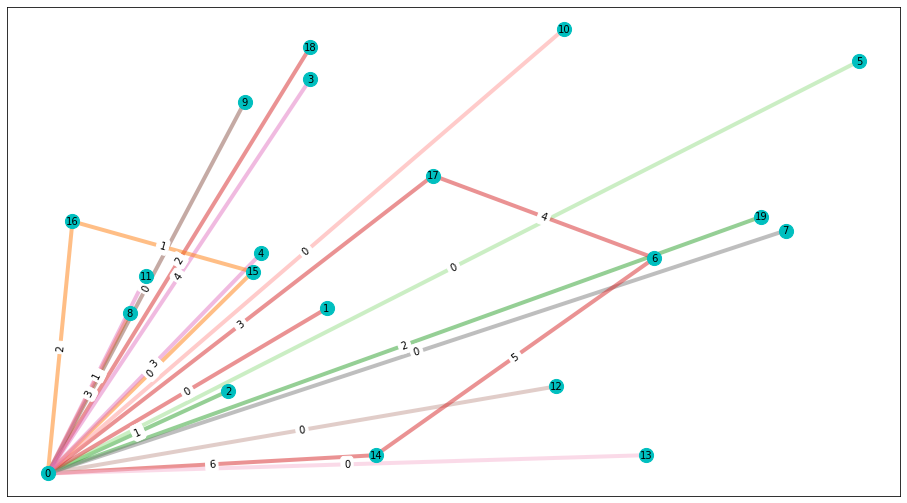

In [54]:
plot_model(domino_list, positions, limit=CLIENTS)